# Transformer core concepts

The outline of this notebook follow closely the blog post _TRANSFORMERS FROM SCRATCH_ by [Peter Boem](https://peterbloem.nl/blog/transformers) with some modifications.


## Self-attention



### General intuition

The attention mechanism is like a teacher who helps you focus on what's important in a classroom. In the same way, the attention mechanism helps the transformer focus on which parts of the input it should be paying attention to, when processing information.

The attention mechanism in transformers allows the model to weigh the importance of different parts of the input, giving more emphasis to the parts that are more relevant to the output.

This is done by computing **attention scores** between each pair of input elements (e.g. words in a sentence) and then using these scores to compute a **weighted sum of the input elements**. The attention **scores are computed using a learned function (_neural network_)** that takes as input both the current input element and a "query" vector that represents the current state of the model.

The resulting **weighted sum is then used as input** to the next layer of the transformer.


### Basic self-attention

We’ll start by implementing this basic self-attention operation in Pytorch. The first thing we should do is work out how to express the self attention in matrix multiplications. 

There are no parameters in basic self-attention (yet). What the basic self-attention actually does is entirely determined by whatever mechanism creates the input sequence. Upstream mechanisms, like an embedding layer, drive the self-attention by learning representations with particular dot products (although we’ll add a few parameters later).

Self attention sees its input as a set, not a sequence. If we permute the input sequence, the output sequence will be exactly the same, except permuted also (i.e. self-attention is permutation equivariant). We will mitigate this somewhat when we build the full transformer, but the self-attention by itself actually ignores the sequential nature of the input.

Let's first define two functions:
 - The `apply_self_attention` function generates random sequences of embeddings, computes raw and scaled weights for each token in the sequence using the self-attention mechanism, and applies the attention to the embeddings to obtain an attention-weighted output.

- The `visualize_self_attention` function takes the input sequence embeddings, raw and scaled weights, and the output after attention, and visualizes them using heatmaps with annotations. The purpose of this function is to provide a graphical representation of the self-attention mechanism for each token in the sequence.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()


def visualize_self_attention(x, raw_weights, weights, y, q=None, k=None, v=None):
    """
    Visualize the self-attention mechanism for each token in a sequence of embeddings.
    """

    fig_scale = 0.8
    fig_width = max(4, x.shape[1]) * fig_scale
    token_fig_height = 0.5 * x.shape[2]
    weight_fig_height = weights.shape[2]
    token_labels = [f"$T_{i}$" for i in range(x.shape[1])]
    weight_labels = [f"$W^T_{i}$" for i in range(weights.shape[1])]
    embedding_labels = [f"$E_{i}$" for i in range(x.shape[2])]
    weight_embedding_labels = [f"$W^E_{i}$" for i in range(weights.shape[2])]
    common_args = dict(
        annot=True,
        cbar=False,
    )

    plt.figure(figsize=(fig_width, token_fig_height))
    sns.heatmap(
        x[0, ::].T,
        xticklabels=token_labels,
        yticklabels=embedding_labels,
        **common_args,
    )
    plt.title("Input embedding values ($S_0$)")
    plt.show()

    if q is not None and k is not None and v is not None:
        for name, value in dict(q=q, k=k, v=v).items():
            plt.figure(figsize=(fig_width, token_fig_height))
            sns.heatmap(
                value[0, ::].T,
                xticklabels=[f"${name.upper()}_{i}$" for i in range(value.shape[1])],
                yticklabels=[f"$W^{name.upper()}_{i}$" for i in range(value.shape[2])],
                ** common_args,
            )
            plt.title(f"{name.upper()} weight values ($S_0$)")
            plt.show()

    plt.figure(figsize=(fig_width, 0.5 * weight_fig_height))
    sns.heatmap(
        raw_weights[0, ::].T,
        xticklabels=weight_labels,
        yticklabels=weight_embedding_labels,
        **common_args,
    )
    plt.title("Raw weights for tokens ($S_0$)")
    plt.show()

    plt.figure(figsize=(fig_width, 0.5 * weight_fig_height))
    sns.heatmap(
        weights[0, ::].T,
        xticklabels=weight_labels,
        yticklabels=weight_embedding_labels,
        **common_args,
    )
    plt.title("Scaled weights for tokens ($S_0$)")
    plt.show()

    plt.figure(figsize=(fig_width, token_fig_height))
    sns.heatmap(
        y[0, ::].T,
        xticklabels=token_labels,
        yticklabels=embedding_labels,
        **common_args,
    )
    plt.title("Self-attention output ($S_0$)")
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F


def apply_self_attention(
    sequences, tokens_in_sequence, embedding_vector_dims, visualize=True
):
    """
    Apply self-attention mechanism to a random sequence of embeddings.
    """
    x = torch.rand(sequences, tokens_in_sequence, embedding_vector_dims)
    print({"x.shape": x.shape})

    raw_weights = torch.bmm(x, x.transpose(1, 2))
    print({"raw_weights.shape": raw_weights.shape})

    weights = F.softmax(raw_weights, dim=2)
    print({"weights.shape": weights.shape})

    y = torch.bmm(weights, x)
    print({"y.shape": y.shape})

    if visualize:
        visualize_self_attention(x, raw_weights, weights, y)


Let's then try to understand what the attention does. Let's begin by looking at a single token sequence.

{'x.shape': torch.Size([1, 1, 4])}
{'raw_weights.shape': torch.Size([1, 1, 1])}
{'weights.shape': torch.Size([1, 1, 1])}
{'y.shape': torch.Size([1, 1, 4])}


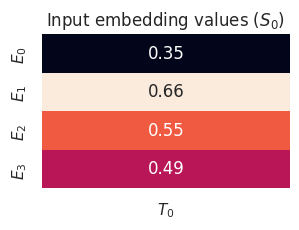

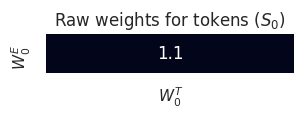

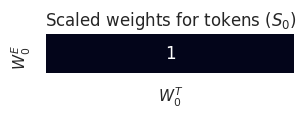

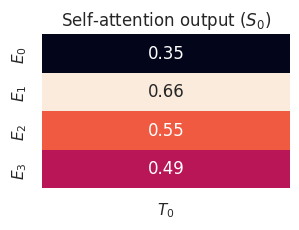

In [4]:

apply_self_attention(
    sequences=1,
    tokens_in_sequence=1,
    embedding_vector_dims=4
)

Due to the softmax scaling function having only a single value to operate upon, the self attention output conforms to the input completely. Weight calculation is just a simple sequence-wise matrix multiplication.

Next, let's take a look at two-token sequence. Note though, that the visualizations consider only the first sequence in any case.

{'x.shape': torch.Size([1, 2, 4])}
{'raw_weights.shape': torch.Size([1, 2, 2])}
{'weights.shape': torch.Size([1, 2, 2])}
{'y.shape': torch.Size([1, 2, 4])}


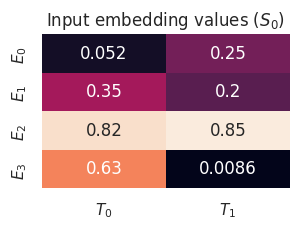

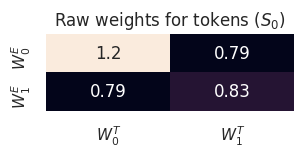

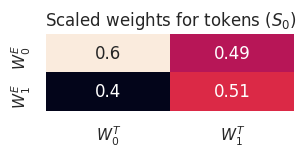

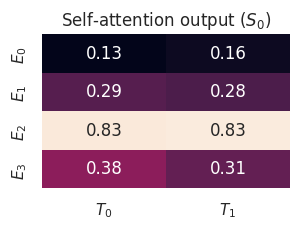

In [5]:

apply_self_attention(
    sequences=1,
    tokens_in_sequence=2,
    embedding_vector_dims=4
)

Here we already see difference between self-attention outputs and inputs. The effects of matrix multiplication show better. Comparing to the single-token sequence, the tokens are more evidently weighted by considering the context of the whole two-token sequence.

### Queries, keys and values

In the basic self-attention we've seen so far, each input vector must play all three roles. We make its life a little easier by deriving new vectors for each role, by applying a linear transformation to the original input vector. 

In a transformer model, the query, key, and value are components of the self-attention mechanism used to compute attention scores between input elements. Overall, the query, key, and value enable the transformer to dynamically focus its attention on the most relevant parts of the input sequence, allowing for more effective processing and prediction. 

- __Query__: An input token vector is compared to every other vector to establish the weights for its own output . Query is used to identify the parts of the input sequence that are most relevant to the current task.

$$x_i \to y_i$$

- __Key__: An input token vector is compared to every other vector to establish the weights for the output of those vectors. Keys are used to "answer" the query by computing a similarity score between the query and each key vector.

$$x_i \to y_j$$

- __Value__: An input token vector vectors is used as part of the weighted sum to compute each output vector once the weights have been established, i.e., to compute the output of the attention mechanism. Specifically, the attention scores between the query and key are used to weight the value vectors, and then a weighted sum of the values is computed to produce the output.

In more mathematical notation: For query $q$, key $k$ and value $v$, three $k \times k$ weigth matrices are added: $W_q$, $W_k$ and $W_v$. The linear transformation is defined as

$$ q_i = W_qx_i \quad k_i = W_kx_i \quad v_i = W_vx_i $$
$$ w'_{ij} = q_i^Tk_j $$
$$ w_{ij} = \text{softmax}(w'_{ij}) $$
$$ y_i =  \sum_jw_{ij}v_j $$

Let's then define an example of the self-attention qith queries, keys and values. We stick to just figuring out the process and leave any architectural definitions of layers and such for later. 

The `apply_self_attention_with_qkv` function applies the self-attention mechanism with query, key, and value components to a random sequence of embeddings. It first generates a random sequence of embeddings and three weight matrices for the query, key, and value components. Then, it computes the query, key, and value vectors by performing matrix multiplication between the weight matrices and the embeddings. The function then computes the raw and scaled weights for each token in the sequence using the self-attention mechanism, and applies the attention to the value vectors to obtain an attention-weighted output.

In [42]:
def apply_self_attention_with_qkv(
    sequences, tokens_in_sequence, embedding_vector_dims, visualize=True
):
    """
    Apply self-attention mechanism with query, key, and value components to a random sequence of embeddings.
"""
    x = torch.rand(sequences, tokens_in_sequence, embedding_vector_dims)
    print({"x.shape": x.shape})

    W_q = torch.rand(sequences, embedding_vector_dims, embedding_vector_dims)
    W_k = torch.rand(sequences, embedding_vector_dims, embedding_vector_dims)
    W_v = torch.rand(sequences, embedding_vector_dims, embedding_vector_dims)

    q = torch.bmm(W_q, x.transpose(1, 2))
    print({"q.shape": q.shape})
    k = torch.bmm(W_k, x.transpose(1, 2))
    print({"k.shape": k.shape})
    v = torch.bmm(W_v, x.transpose(1, 2))
    print({"v.shape": v.shape})

    raw_weights = torch.bmm(q, k.transpose(1, 2))
    print({"raw_weights.shape": raw_weights.shape})

    weights = F.softmax(raw_weights, dim=2)
    print({"weights.shape": weights.shape})

    y = torch.bmm(weights, v).transpose(1,2)
    print({"y.shape": y.shape})

    if visualize:
        visualize_self_attention(
            x,
            raw_weights,
            weights,
            y,
            q.transpose(1, 2),
            k.transpose(1, 2),
            v.transpose(1, 2),
        )


{'x.shape': torch.Size([1, 1, 4])}
{'q.shape': torch.Size([1, 4, 1])}
{'k.shape': torch.Size([1, 4, 1])}
{'v.shape': torch.Size([1, 4, 1])}
{'raw_weights.shape': torch.Size([1, 4, 4])}
{'weights.shape': torch.Size([1, 4, 4])}
{'y.shape': torch.Size([1, 1, 4])}


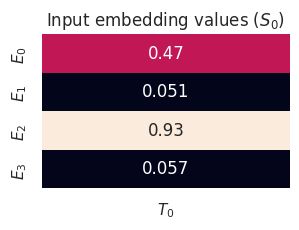

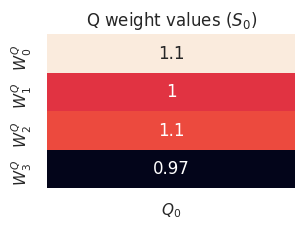

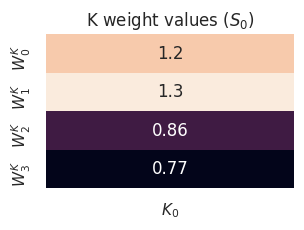

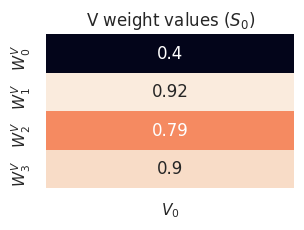

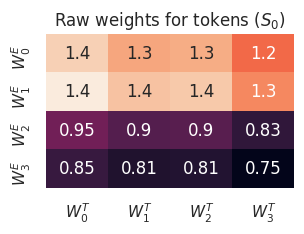

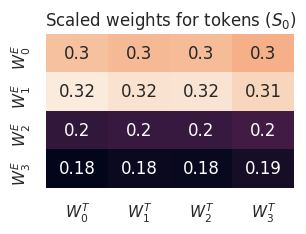

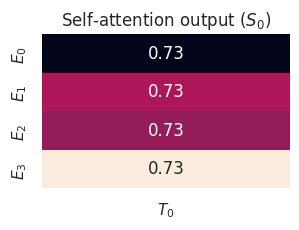

In [53]:
apply_self_attention_with_qkv(
    sequences=1,
    tokens_in_sequence=1,
    embedding_vector_dims=4
)

{'x.shape': torch.Size([1, 2, 4])}
{'q.shape': torch.Size([1, 4, 2])}
{'k.shape': torch.Size([1, 4, 2])}
{'v.shape': torch.Size([1, 4, 2])}
{'raw_weights.shape': torch.Size([1, 4, 4])}
{'weights.shape': torch.Size([1, 4, 4])}
{'y.shape': torch.Size([1, 2, 4])}


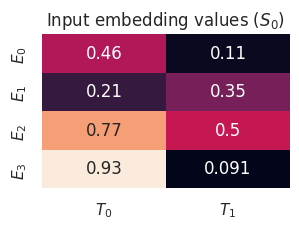

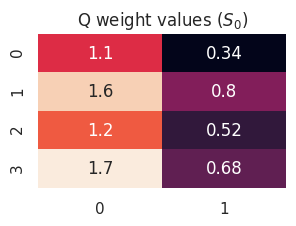

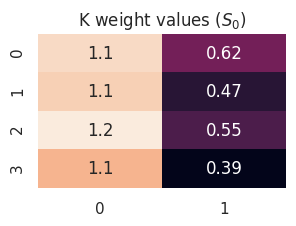

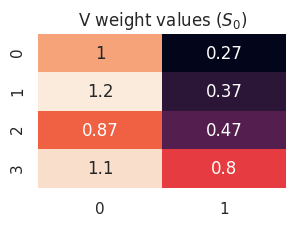

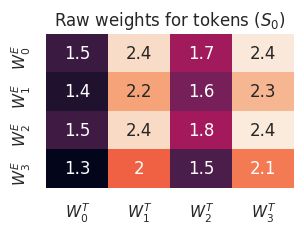

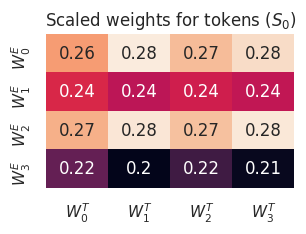

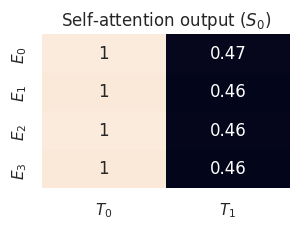

In [45]:
apply_self_attention_with_qkv(
    sequences=1,
    tokens_in_sequence=2,
    embedding_vector_dims=4
)